In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyhacores.utils import *
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

from pyhacores.radio import QuadratureDemodulator
simulations = ['MODEL', 'PYHA']

# Applications

## Analog FM demodulator

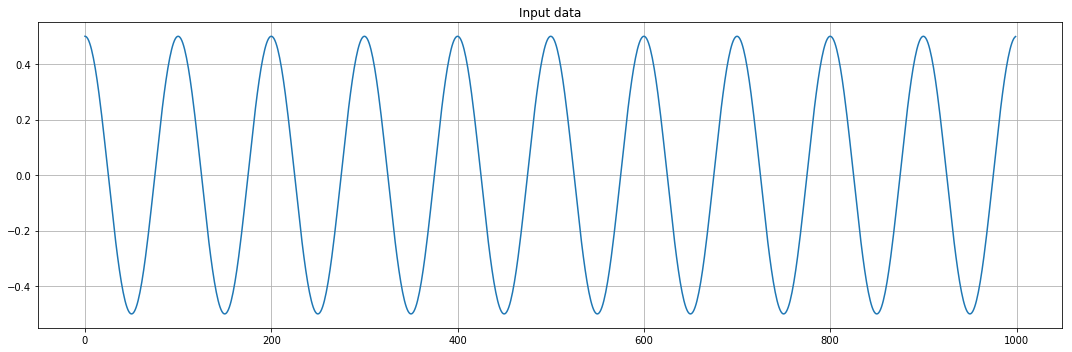

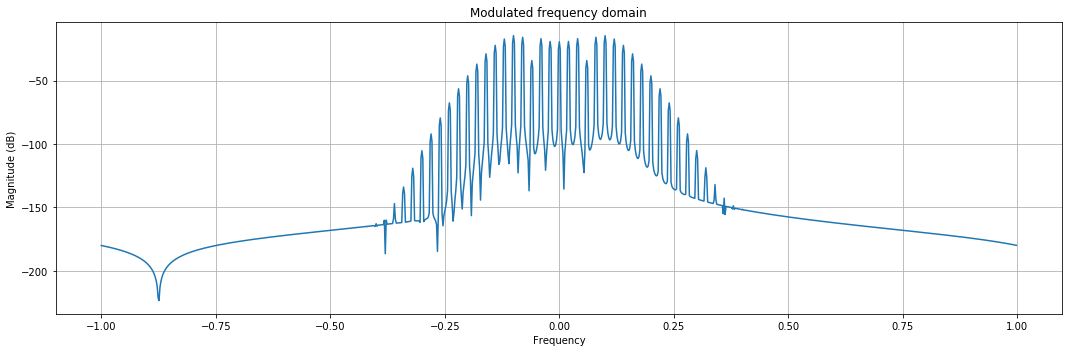

In [3]:
""" Amplitude modulated chirp signal """
fs = 1e3
deviation = fs / 8
periods = 1
data_freq = 10
time = np.linspace(0, periods, fs * periods, endpoint=False)
data = np.cos(2 * np.pi * data_freq * time) * 0.5

# modulate
sensitivity = 2 * np.pi * deviation / fs
phl = np.cumsum(sensitivity * data)
modulated_signal = np.exp(phl * 1j) * 0.5
plt.title('Input data')
plt.plot(data)
show_plot()

plt.title('Modulated frequency domain')
plt.magnitude_spectrum(modulated_signal, scale='dB')
show_plot()

In [4]:
demod_gain = fs / (2 * np.pi * deviation)
dut = QuadratureDemodulator(demod_gain)
sims = simulate(dut, modulated_signal, simulations=simulations, discard_last_n_outputs=1)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/1019 [00:00<?, ?it/s]

100%|██████████| 1019/1019 [00:01<00:00, 556.61it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [5]:
assert sims_close(sims, rtol=1e-2, atol=1e-4)

INFO:sim:sims_close(rtol=0.01, atol=0.0001)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [6]:
print(f"SNR: {snr(sims['MODEL'][:-1], sims['PYHA'][:-1])} dB")

SNR: 70.92716784673061 dB


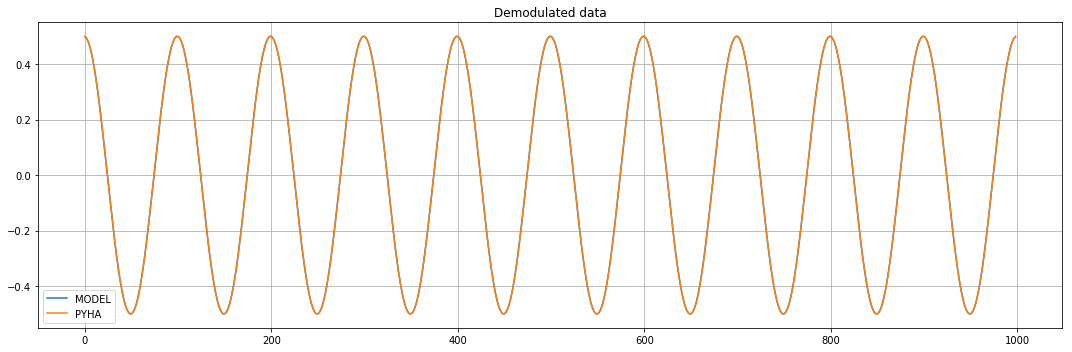

In [7]:
plt.title('Demodulated data')
for key, value in sims.items():
    plt.plot(value, label=key)
show_plot()

## FSK demodulator


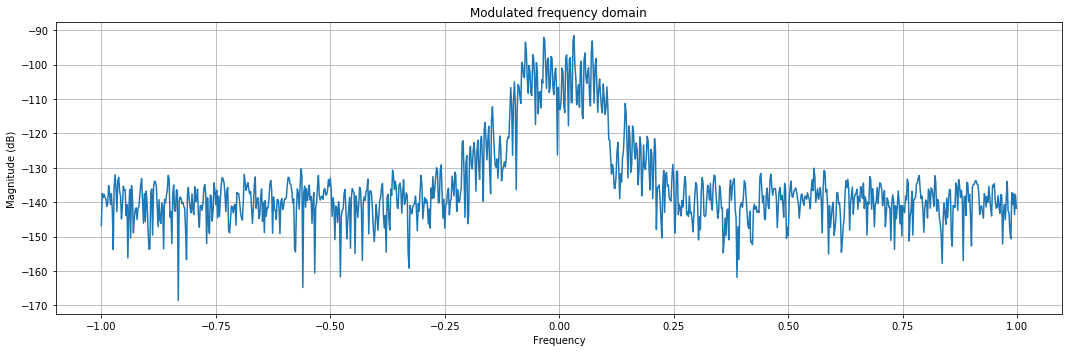

In [8]:
from pathlib import Path
import pyhacores
path = Path(pyhacores.__path__[0]) / '../data/f2404_fs16.896_one_hop.iq'
iq = load_iq(str(path))[19000:20000] # this part has only bits..i.e no noisy stuff
iq *= 0.0001 # very low power signal


iq = [Complex(x, 0, -17).val for x in iq]
plt.title('Modulated frequency domain')
plt.magnitude_spectrum(iq, scale='dB')
show_plot()


In [9]:
demod_gain = 1/np.pi*10
dut = QuadratureDemodulator(demod_gain)
sims = simulate(dut, iq, simulations=simulations,  discard_last_n_outputs=1)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/1019 [00:00<?, ?it/s]

 97%|█████████▋| 992/1019 [00:01<00:00, 543.20it/s]

100%|██████████| 1019/1019 [00:01<00:00, 542.01it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


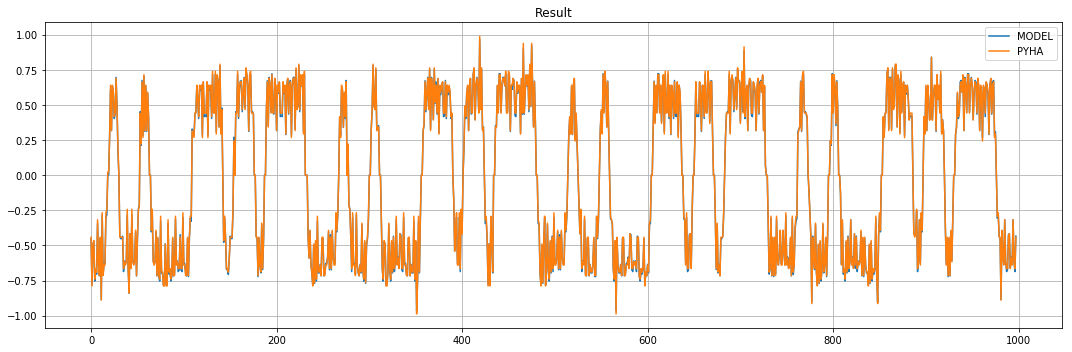

In [10]:
plt.title('Result')
for key, value in sims.items():
    plt.plot(value[:-1], label=key)
show_plot()

In [11]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA'])} dB")

SNR: 33.97727619674771 dB


# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [12]:
print(f'Minimum number representabe: {2**-17}')

Minimum number representabe: 7.62939453125e-06


## Cant match the model on noise signal

In [13]:
path = Path(pyhacores.__path__[0]) / '../data/f2404_fs16.896_one_hop.iq'
iq = load_iq(str(path))[17000:18000] # this part has only noise
iq *= 0.001 # very low power signal


In [14]:
demod_gain = 1/np.pi
dut = QuadratureDemodulator(demod_gain)
sims = simulate(dut, iq, simulations=simulations, discard_last_n_outputs=1)

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1019/1019 [00:01<00:00, 556.86it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


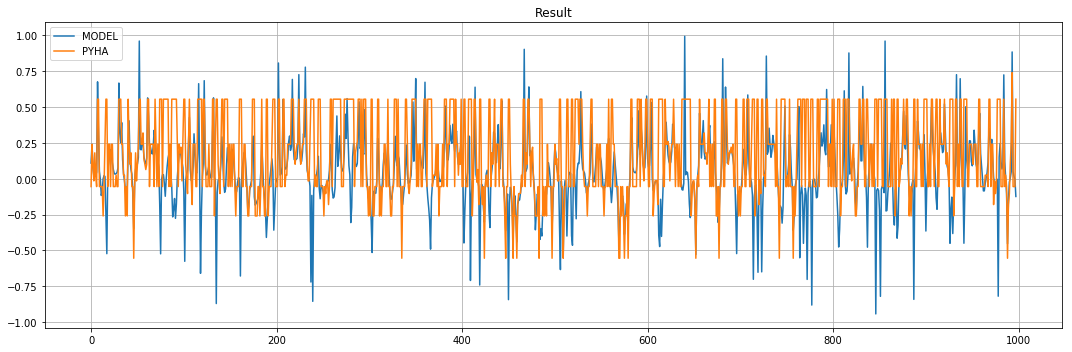

In [15]:
plt.title('Result')
for key, value in sims.items():
    plt.plot(value[:-1], label=key)
show_plot()

## Last output sample is junk
use `simulate(..., discard_last_n_outputs=1)` to get rid of it.

# Synthesis

In [16]:
# NBVAL_IGNORE_OUTPUT
c = convertToVHDL(dut, '/tmp/pyha_output')
_ = c.make_quartus_netlist()

INFO:conversion:Creating top.vhd ...
INFO:conversion:Cordic to VHDL ...
INFO:conversion:ToPolar to VHDL ...
INFO:conversion:Angle to VHDL ...
INFO:conversion:QuadratureDemodulator to VHDL ...
INFO:sim:Running quartus map...will take time.
INFO:sim:Analysis & Synthesis Status : Successful - Fri Aug  3 15:35:13 2018
INFO:sim:Quartus Prime Version : 17.1.0 Build 590 10/25/2017 SJ Lite Edition
INFO:sim:Revision Name : quartus_project
INFO:sim:Top-level Entity Name : top
INFO:sim:Family : Cyclone IV E
INFO:sim:Total logic elements : 2,533
INFO:sim:    Total combinational functions : 2,479
INFO:sim:    Dedicated logic registers : 1,520
INFO:sim:Total registers : 1520
INFO:sim:Total pins : 56
INFO:sim:Total virtual pins : 0
INFO:sim:Total memory bits : 0
INFO:sim:Embedded Multiplier 9-bit elements : 8
INFO:sim:Total PLLs : 0
INFO:sim:Running netlist writer.


In [17]:
print(f'Logic elements: {c.last_logic_elements}')
print(f'Memory: {c.last_memory_bits}')
print(f'Multipler (18bit): {c.last_multiplier//2}')

Logic elements: 2533
Memory: 0
Multipler (18bit): 4
